<a href="https://colab.research.google.com/github/manikur/R-programming/blob/main/Motherson_Sumi_Systems_Stock_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Motherson Sumi Systems Stock price target

In [1]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 11.6 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=ebc4ceb258aa20860a365932a7493bc12373163cd35b885f2086a8d2e9a61410
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import yfinance as yf
import numpy as np
import os
import random
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import (Dataset, TensorDataset,
 DataLoader, Subset)
from collections import OrderedDict
from sklearn.metrics import mean_squared_error

In [3]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [41]:
df = yf.download('MOTHERSUMI.NS',
 start='2010-01-01',
 end='2021-08-11',
 adjusted=True,
 progress=False)

In [42]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-04,238.800003,242.649994,235.449997,236.500000,236.500000,7288027
2021-08-05,235.800003,239.300003,234.350006,236.899994,236.899994,4091862
2021-08-06,236.000000,241.000000,234.449997,236.149994,236.149994,3983431
2021-08-09,239.399994,239.399994,227.300003,230.899994,230.899994,10617093
2021-08-10,231.199997,237.199997,220.649994,223.199997,223.199997,38090593


In [43]:
df = df.loc[:, ['Adj Close']]

In [44]:
df.rename(columns={'Adj Close': 'price'}, inplace=True)

In [12]:
df = df.resample('M').last()

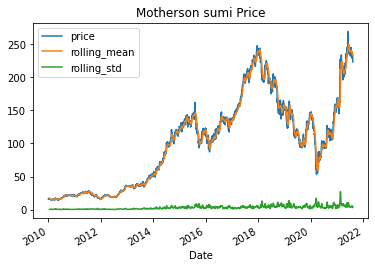

In [45]:
WINDOW_SIZE = 12
df['rolling_mean'] = df.price.rolling(window=WINDOW_SIZE).mean()
df['rolling_std'] = df.price.rolling(window=WINDOW_SIZE).std()
df.plot(title='Motherson sumi Price')

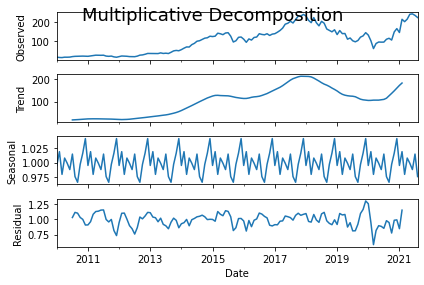

In [14]:
decomposition_results = seasonal_decompose(df.price,
 model='multiplicative')
decomposition_results.plot() \
 .suptitle('Multiplicative Decomposition',
 fontsize=18);

In [15]:
import pandas as pd
import seaborn as sns
from fbprophet import Prophet

In [22]:
df = yf.download('MOTHERSUMI.NS',
 start='2010-01-01',
 end='2021-08-11',
 adjusted=True,
 progress=False)

In [23]:
df = df.loc[:, ['Adj Close']]

In [24]:
df.reset_index(drop=False, inplace=True)
df.rename(columns={'Date': 'ds', 'Adj Close': 'y'}, inplace=True)

In [25]:
train_indices = df.ds.apply(lambda x: x.year) < 2021
df_train = df.loc[train_indices].dropna()
df_test = df.loc[~train_indices].reset_index(drop=True)

In [26]:
model_prophet = Prophet(seasonality_mode='additive')
model_prophet.add_seasonality(name='monthly', period=30.5,fourier_order=5)
model_prophet.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


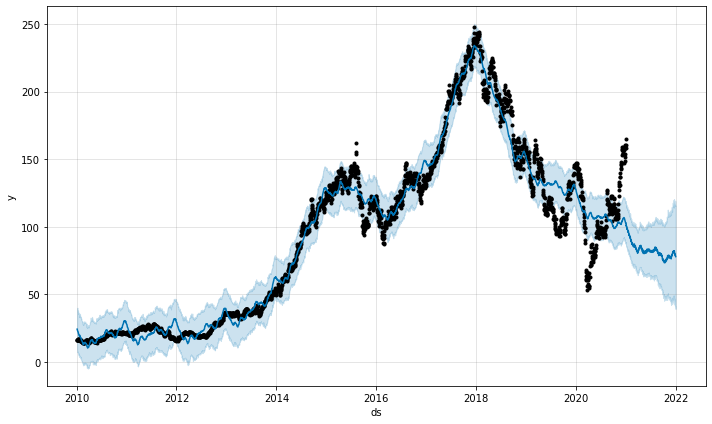

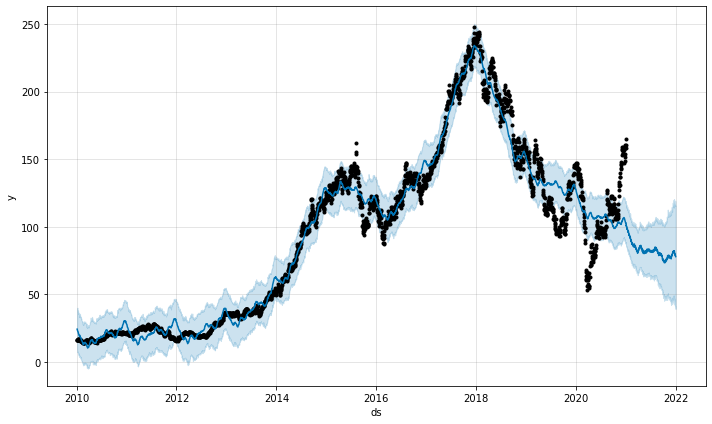

In [47]:
df_future = model_prophet.make_future_dataframe(periods=365)
df_pred = model_prophet.predict(df_future)
model_prophet.plot(df_pred)

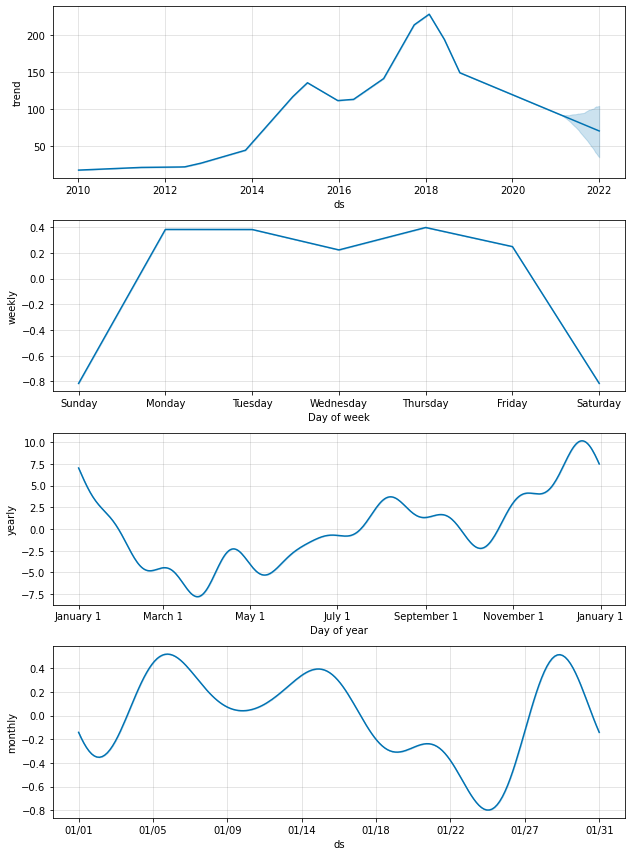

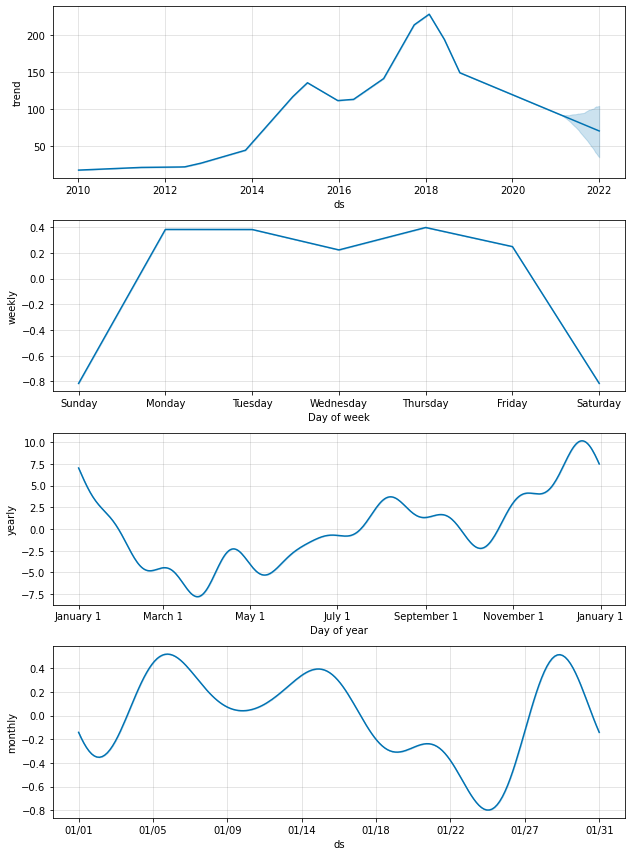

In [48]:
model_prophet.plot_components(df_pred)

In [29]:
selected_columns = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']

In [30]:
df_pred = df_pred.loc[:, selected_columns].reset_index(drop=True)
df_test = df_test.merge(df_pred, on=['ds'], how='left')
df_test.ds = pd.to_datetime(df_test.ds)
df_test.set_index('ds', inplace=True)

In [31]:
import matplotlib.pyplot as plt

[Text(0, 0.5, 'Stock Price '),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Stock Price - actual vs. predicted')]

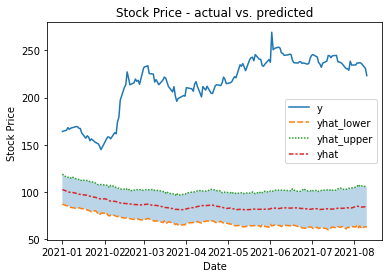

In [33]:
fig, ax = plt.subplots(1, 1)
ax = sns.lineplot(data=df_test[['y', 'yhat_lower', 'yhat_upper','yhat']])
ax.fill_between(df_test.index,
 df_test.yhat_lower,
 df_test.yhat_upper,
 alpha=0.3)
ax.set(title='Stock Price - actual vs. predicted',
 xlabel='Date',
 ylabel='Stock Price ')

In [34]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

In [35]:
def adf_test(x):
 indices = ['Test Statistic', 'p-value',
 '# of Lags Used', '# of Observations Used']
 adf_test = adfuller(x, autolag='AIC')
 results = pd.Series(adf_test[0:4], index=indices)
 for key, value in adf_test[4].items():
  results[f'Critical Value ({key})'] = value
 return results

In [36]:
adf_test(df.y)

Test Statistic              -0.813572
p-value                      0.815103
# of Lags Used               0.000000
# of Observations Used    2860.000000
Critical Value (1%)         -3.432639
Critical Value (5%)         -2.862551
Critical Value (10%)        -2.567308
dtype: float64

In [37]:
def kpss_test(x, h0_type='c'):
 indices = ['Test Statistic', 'p-value', '# of Lags']
 kpss_test = kpss(x, regression=h0_type)
 results = pd.Series(kpss_test[0:3], index=indices)
 for key, value in kpss_test[3].items():
  results[f'Critical Value ({key})'] = value
 return results

In [38]:
kpss_test(df.y)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



Test Statistic            7.127252
p-value                   0.010000
# of Lags                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

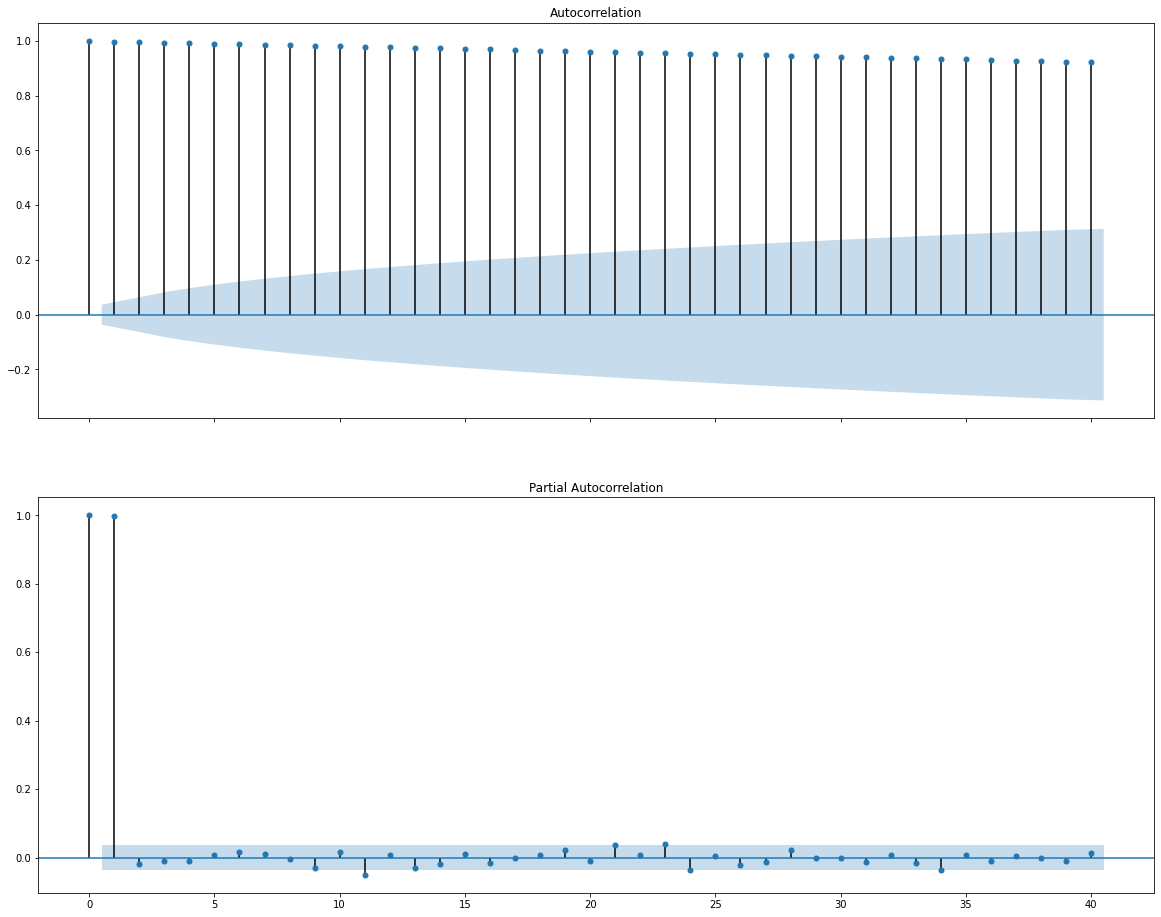

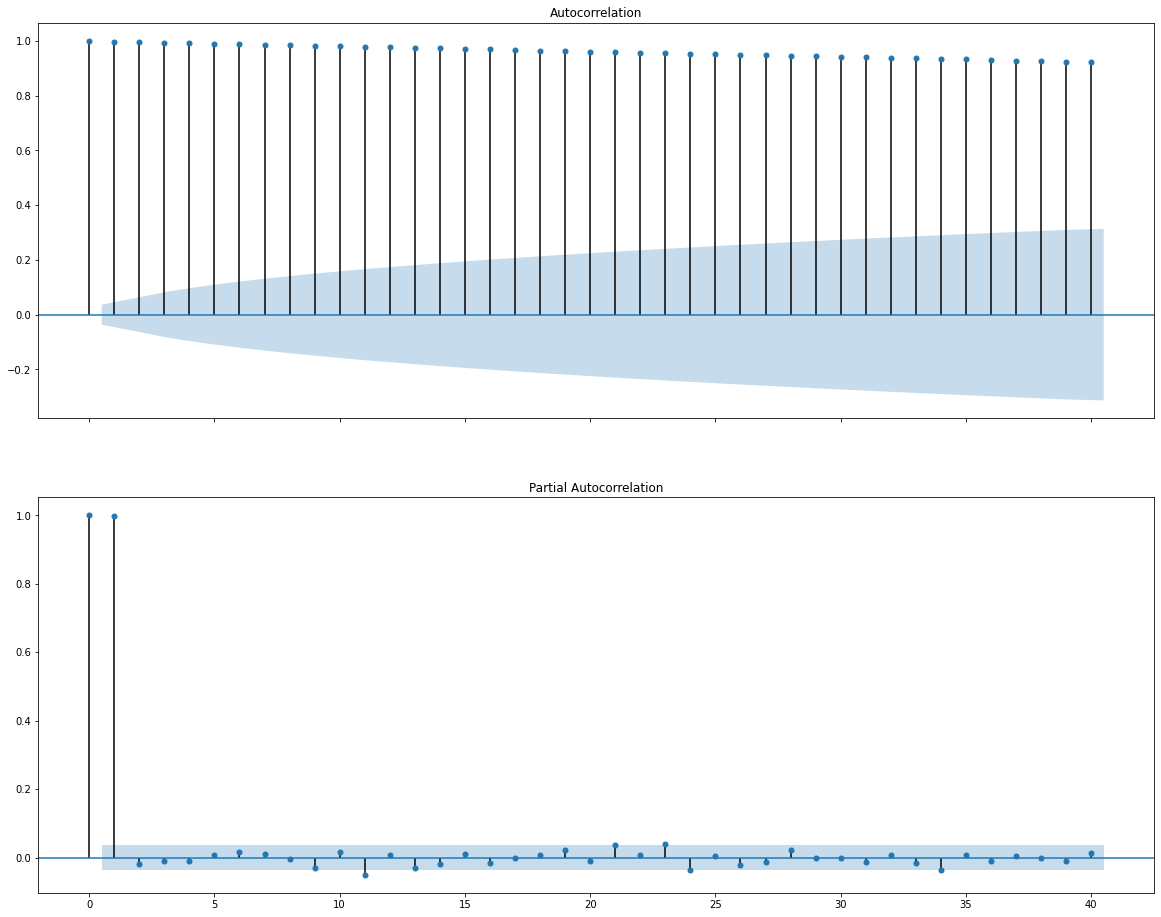

In [39]:
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05
fig, ax = plt.subplots(2, 1, figsize=(20, 16), sharex=True)
plot_acf(df.y, ax=ax[0], lags=N_LAGS,
 alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df.y, ax=ax[1], lags=N_LAGS,
 alpha=SIGNIFICANCE_LEVEL)